In [1]:
import torch
from trainer import *
from torch.utils.data import DataLoader
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from models.CNN import StrainEnergyCANN_C, StrainEnergyCANN_polinomial3
from sklearn.metrics import r2_score


# Предобработка данных

In [2]:
path = r"C:\Users\User\PycharmProjects\data-driven-constitutive-modelling\data\brain_bade\CANNsBRAINdata.xlsx"

In [3]:
I1_tc = lambda lam: lam ** 2 + 2.0 / lam
I2_tc = lambda lam: 2.0 * lam + 1 / lam ** 2
I1_s = lambda gam: gam ** 2 + 3.0
F_tc = lambda lam: ([lam, 0, 0], [0, lam **(-0.5), 0], [0, 0, lam**(-0.5)])
F_s = lambda gam: ([1., gam, 0], [0, 1., 0], [0, 0, 1.])


In [4]:
all_data = pd.read_excel(path, sheet_name="Sheet1", header=[1, 2, 3])
brain_CR_TC_data = all_data.filter(like="CR-comten").copy()
brain_CR_S_data  = all_data.filter(like="CR-shr").copy().dropna(axis=1)

brain_CR_TC_data.columns = brain_CR_TC_data.columns.droplevel(level=[0, 2])
brain_CR_S_data.columns  = brain_CR_S_data.columns.droplevel(level=[0, 2])

mechanical_variables = {
    "I1": [I1_tc, I1_s],
    "I2": [I2_tc, I1_s],
    "F":  [F_tc, F_s],
    # "exp_type": [(lambda x: 1), (lambda x: 0)] # 1 - torsion&compression, 0 - shear
    # "torsion_compression": (lambda x: 1)
}

# calculate I1, I2, F from lambda (torsion&compression and shear)
for variable in mechanical_variables.keys():
    func_calc = mechanical_variables.get(variable)
    brain_CR_TC_data[variable] = brain_CR_TC_data["lambda"].apply(func_calc[0])
    brain_CR_S_data[variable]  = brain_CR_S_data["gamma"].apply(func_calc[1])
    # I1 = pd.concat([brain_CR_TC_data[variable], brain_CR_S_data[variable]], ignore_index=True)
brain_CR_S_data["lambda"] = brain_CR_S_data.pop("gamma")
brain_CR_TC_data["exp_type"] = ["Compression" if i < len(brain_CR_TC_data) / 2 else "Tensile"  for i in range(len(brain_CR_TC_data))]
brain_CR_S_data["exp_type"] = ["Shear"  for i in range(len(brain_CR_S_data))]
data = pd.concat([brain_CR_TC_data, brain_CR_S_data], ignore_index=True)


In [5]:
combined_data = data
combined_data.columns = ['lambda', 'P_experimental', 'I1', 'I2', 'F', 'experiment_type']

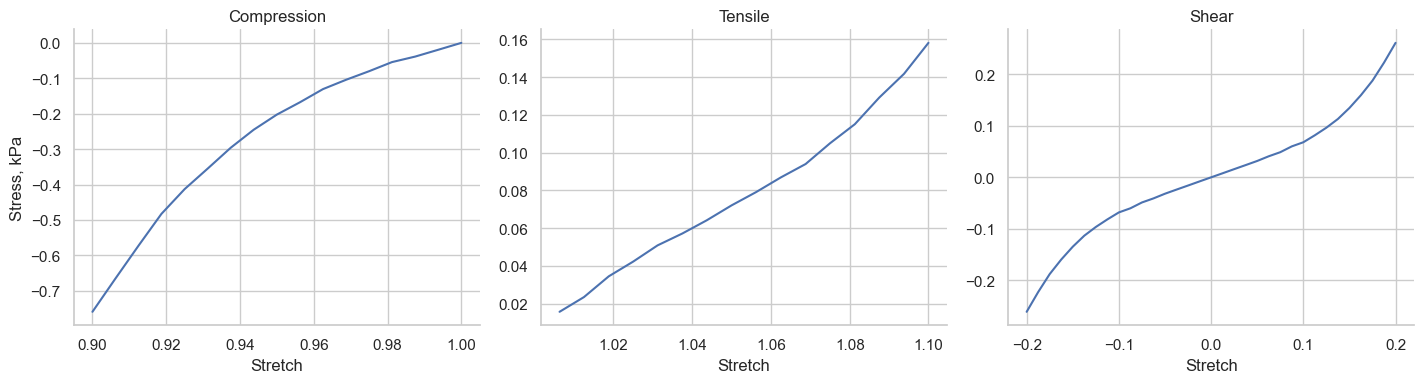

In [6]:
sns.set(style="whitegrid")
g = sns.relplot(
    data=combined_data,
    x='lambda', y='P_experimental', col='experiment_type', kind='line', height=4, aspect=1.2, facet_kws={'sharey': False, 'sharex': False}
)

# Update axis labels
g.set_axis_labels("Stretch", "Stress, kPa")
g.set_titles("{col_name}")
plt.savefig("brain")

plt.show()


In [7]:
combined_data

,lambda,P_experimental,I1,I2,F,experiment_type
0,0.9000,-0.7591,3.032222,3.034568,"([0.9, 0, 0], [0, 1.0540925533894598, 0], [0, ...",Compression
1,0.9062,-0.6657,3.028217,3.030132,"([0.9062, 0, 0], [0, 1.0504804420483138, 0], [...",Compression
2,0.9125,-0.5723,3.024437,3.025976,"([0.9125, 0, 0], [0, 1.0468478451804275, 0], [...",Compression
3,0.9187,-0.4827,3.020999,3.022221,"([0.9187, 0, 0], [0, 1.0433094516736974, 0], [...",Compression
4,0.9250,-0.4127,3.017787,3.018736,"([0.925, 0, 0], [0, 1.0397504898200727, 0], [0...",Compression
...,...,...,...,...,...,...
61,0.1500,0.1347,3.022500,3.022500,"([1.0, 0.15, 0], [0, 1.0, 0], [0, 0, 1.0])",Shear
62,0.1625,0.1596,3.026406,3.026406,"([1.0, 0.1625, 0], [0, 1.0, 0], [0, 0, 1.0])",Shear
63,0.1750,0.1878,3.030625,3.030625,"([1.0, 0.175, 0], [0, 1.0, 0], [0, 0, 1.0])",Shear
64,0.1875,0.2227,3.035156,3.035156,"([1.0, 0.1875, 0], [0, 1.0, 0], [0, 0, 1.0])",Shear


In [8]:
from torch.utils.data import DataLoader, random_split, Dataset, TensorDataset
import copy 

class CustomDataset(Dataset):
    def __init__(self, dataframe):
        self.data = dataframe
        # self.features = [dataframe[0],dataframe[2], dataframe[3], dataframe[4], dataframe[5]]
        # self.targets  = dataframe[1]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        features = copy.deepcopy([*self.data.iloc[idx]][:6])
        target = features.pop(1)

        return features, target

    def to_tensor(self):
        for column in self.data.columns:
            if column != "experiment_type":
                self.data[column] = self.data[column].apply(
                    lambda x: torch.tensor(x, dtype=torch.float32)).copy()


In [9]:
# start = 0
# end = 49
# train_dataset = CustomDataset(combined_data[start:end].copy())
# test_dataset = CustomDataset(combined_data.copy())
# f, t = train_dataset[0]
# lam, i1, i2, F, exp_type = f
# print(f)

In [10]:
experiments = ["Shear", "Tensile"]
d = pd.concat([combined_data[combined_data["experiment_type"] == experiment] for experiment in experiments]).reset_index(drop=True, inplace=False)
d

,lambda,P_experimental,I1,I2,F,experiment_type
0,-0.2000,-0.2611,3.040000,3.040000,"([1.0, -0.2, 0], [0, 1.0, 0], [0, 0, 1.0])",Shear
1,-0.1875,-0.2227,3.035156,3.035156,"([1.0, -0.1875, 0], [0, 1.0, 0], [0, 0, 1.0])",Shear
2,-0.1750,-0.1878,3.030625,3.030625,"([1.0, -0.175, 0], [0, 1.0, 0], [0, 0, 1.0])",Shear
3,-0.1625,-0.1596,3.026406,3.026406,"([1.0, -0.1625, 0], [0, 1.0, 0], [0, 0, 1.0])",Shear
4,-0.1500,-0.1347,3.022500,3.022500,"([1.0, -0.15, 0], [0, 1.0, 0], [0, 0, 1.0])",Shear
5,-0.1375,-0.1133,3.018906,3.018906,"([1.0, -0.1375, 0], [0, 1.0, 0], [0, 0, 1.0])",Shear
6,-0.1250,-0.0964,3.015625,3.015625,"([1.0, -0.125, 0], [0, 1.0, 0], [0, 0, 1.0])",Shear
7,-0.1125,-0.0817,3.012656,3.012656,"([1.0, -0.1125, 0], [0, 1.0, 0], [0, 0, 1.0])",Shear
8,-0.1000,-0.0681,3.010000,3.010000,"([1.0, -0.1, 0], [0, 1.0, 0], [0, 0, 1.0])",Shear
9,-0.0875,-0.0601,3.007656,3.007656,"([1.0, -0.0875, 0], [0, 1.0, 0], [0, 0, 1.0])",Shear


In [11]:
def init_loaders(experiments=["Shear", "Tensile", "Comression"]):
    if type(experiments) == str:
        experiments = [experiments]
    print(experiments)
    
    df = pd.concat([combined_data[combined_data["experiment_type"] == experiment] for experiment in experiments]).reset_index(drop=True, inplace=False)
    train_dataset = CustomDataset(df.copy())
    test_dataset = CustomDataset(combined_data.copy())
    
    train_dataset.to_tensor()
    test_dataset.to_tensor()
    
    train_data_loader = DataLoader(
                            train_dataset,
                            shuffle=True,
                            # num_workers=1,
                            pin_memory=False
    )
    test_data_loader = DataLoader(
                            test_dataset,
                            shuffle=False,
                            # num_workers=1,
                            pin_memory=False
    )

    return train_data_loader, test_data_loader 

In [12]:
train_data_loader, test_data_loader = init_loaders("Compression")
train_data_loader.dataset.data

['Compression']


,lambda,P_experimental,I1,I2,F,experiment_type
0,tensor(0.9000),tensor(-0.7591),tensor(3.0322),tensor(3.0346),"[[tensor(0.9000), tensor(0.), tensor(0.)], [te...",Compression
1,tensor(0.9062),tensor(-0.6657),tensor(3.0282),tensor(3.0301),"[[tensor(0.9062), tensor(0.), tensor(0.)], [te...",Compression
2,tensor(0.9125),tensor(-0.5723),tensor(3.0244),tensor(3.0260),"[[tensor(0.9125), tensor(0.), tensor(0.)], [te...",Compression
3,tensor(0.9187),tensor(-0.4827),tensor(3.0210),tensor(3.0222),"[[tensor(0.9187), tensor(0.), tensor(0.)], [te...",Compression
4,tensor(0.9250),tensor(-0.4127),tensor(3.0178),tensor(3.0187),"[[tensor(0.9250), tensor(0.), tensor(0.)], [te...",Compression
5,tensor(0.9313),tensor(-0.3543),tensor(3.0149),tensor(3.0156),"[[tensor(0.9313), tensor(0.), tensor(0.)], [te...",Compression
6,tensor(0.9375),tensor(-0.2959),tensor(3.0122),tensor(3.0128),"[[tensor(0.9375), tensor(0.), tensor(0.)], [te...",Compression
7,tensor(0.9437),tensor(-0.2453),tensor(3.0099),tensor(3.0103),"[[tensor(0.9437), tensor(0.), tensor(0.)], [te...",Compression
8,tensor(0.9500),tensor(-0.2024),tensor(3.0078),tensor(3.0080),"[[tensor(0.9500), tensor(0.), tensor(0.)], [te...",Compression
9,tensor(0.9563),tensor(-0.1674),tensor(3.0059),tensor(3.0061),"[[tensor(0.9563), tensor(0.), tensor(0.)], [te...",Compression


# Обучение модели

In [13]:
experiments=[["Shear", "Tensile", "Comression"],["Tensile", "Comression"], ["Tensile", "Shear"], ["Shear", "Comression"], "Shear", "Tensile", "Comression"]
for experiment in experiments:
    print(experiment)

['Shear', 'Tensile', 'Comression']
['Tensile', 'Comression']
['Tensile', 'Shear']
['Shear', 'Comression']
Shear
Tensile
Comression


In [14]:
# Переименуем столбцы для удобства
# data.columns = ['strain', 'measured_force', 'I1', 'I2', 'F', 'experiment_type', 'predicted_force']

# Удалим ненужные столбцы
# data = data[['strain', 'measured_force', 'experiment_type', 'predicted_force']]
def plot_results(data:pd.DataFrame, plot_name=""):
    # Преобразуем столбец с предсказанной силой в числовой формат
    data['P_model_' + plot_name] = data['P_model_' + plot_name].apply(lambda x: float(str(x).strip('[]')))
    
    # Создадим графики для каждого типа эксперимента
    experiment_types = data['experiment_type'].unique()
    def plot_with_r2(data, experiment_types):
        r2_scores = []
        fig, axes = plt.subplots(1, len(experiment_types), figsize=(15, 6), sharey=False)
        
        for ax, experiment in zip(axes, experiment_types):
            subset = data[data['experiment_type'] == experiment]
            r2 = r2_score(subset['P_experimental'], subset['P_model_' + plot_name])
            
            sns.scatterplot(data=subset, x='lambda', y='P_experimental', label='P_experimental', ax=ax)
            sns.lineplot(data=subset, x='lambda', y='P_model_' + plot_name, label='P_model', color='orange', ax=ax)
            ax.set_title(f'Experiment Type: {experiment}\nR² = {r2:.2f}')
            ax.set_xlabel('Strain')
            ax.set_ylabel('Force (kPa)')
            r2_scores.append(r2)
        
        plt.tight_layout()
        plt.savefig(plot_name)
        plt.show()
        
        return r2_scores
    # Вызовем функцию для построения графиков с r2
    plot_with_r2(data, experiment_types)

In [ ]:
experiments=[["Tensile", "Comression"], ["Tensile", "Shear"], ["Shear", "Comression"], "Shear", "Tensile", "Compression"]
# experiments = ["Tensile", "Comression", "Shear"]
# models = [StrainEnergyCANN_C, StrainEnergyCANN_polinomial3]
models = [StrainEnergyCANN_C]
path = r"C:\Users\User\PycharmProjects\data-driven-constitutive-modelling\src\CANN_torch\pretrained_models"
best_model_path = r"pretrained_models\brain_StrainEnergyCANN_C\20240523_1820_1400.pth"
for model in models:

    # for idx, experiment in enumerate(experiments):
        train_data_loader, test_data_loader = init_loaders()
        name = "brain_" + str(model.__name__)
        print("----------------------------------------------------------------------")
        print(experiment)
        test_train = Trainer(
            plot_valid=False,
            epochs=3500,
            experiment_name=name,
            l2_reg_coeff=0.0001,
            learning_rate=0.0001,
            checkpoint=best_model_path,
            model=model
            # dtype = torch.float64
        )
        
        trained_model = test_train.train(train_data_loader, None, weighting_data=True)
    
        trained_model.eval()
        vpredictions = []
        vtargets = []
        for data in test_data_loader:
            features, target = data
            vpredictions.append(trained_model(features).detach().numpy())
        print(trained_model.get_potential())
        
        combined_data["P_model_" + name] = vpredictions
        plot_results(combined_data, name)
        combined_data.to_csv(os.path.join(os.path.join(path, str(name)), "data.csv"))
        combined_data.pop("P_model_" + name)
# trained_model = StrainEnergyCANN_C()


# print("R2:", r2_score_own(vtargets, vpredictions))
# plt.figure(figsize=(10, 5))
# plt.plot(vpredictions, label='P_pred', color='red')
# plt.plot(vtargets, label='P_true', color='black')
# plt.xlabel('lambda/gamma')
# plt.ylabel('P')
# plt.title('Predictions vs. Targets')
# plt.legend()

# plt.show()

['Shear', 'Tensile', 'Comression']
----------------------------------------------------------------------
Comression
Directory pretrained_models\brain_StrainEnergyCANN_C already exists
------------------------------------------------------------------
Epoch [1/3500], Loss: 0.01004629, Test metric: 0.01004629
psi =   0.000000 * (I1 - 3) \\               + 0.000000 * (e^{  0.000000 * (I1 - 3)} - 1)\\               - 0.000000 * ln(1 - 0.000000 * (I1 - 3)) \\               + 0.020934 * (I1 - 3) ^ 2 \\               + 0.151754 * (e^{  0.153516 * (I1 - 3) ^ 2} - 1)\\               - 0.000000 * ln(1 - 0.000000 * (I1 - 3) ^ 2) \\                               + 0.000000 * (I2 - 3) \\               + 0.000000 * (e^{  0.000000 * (I2 - 3))} - 1)\\               - 1.942346* ln(1 - 0.000000 *  (I2 - 3)) \\               + 0.000000 * (I2 - 3) ^ 2 \\               + 1.923965 * (e^{  1.965323 *(I2 - 3) ^ 2)} - 1)\\               - 0.000000* ln(1 - 0.000000 * (I2 - 3) ^ 2)\\
---------------------------

In [16]:
best_model_path = r"C:\Users\drani\dd\data-driven-constitutive-modelling\src\CANN_torch\pretrained_models\PDMS_full\20240522_1718_533.pth"
trained_model = StrainEnergyCANN_polinomial3()
trained_model.load_state_dict(torch.load(best_model_path))
trained_model.eval()
vpredictions = []
vtargets = []
for data in test_data_loader:
    features, target = data
    vpredictions.append(trained_model(features).detach().numpy())
print(trained_model.get_potential())
combined_data["P_model"] = vpredictions

plot_results(combined_data)

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\drani\\dd\\data-driven-constitutive-modelling\\src\\CANN_torch\\pretrained_models\\PDMS_full\\20240522_1718_533.pth'

In [ ]:
best_model_path = r"C:\Users\drani\dd\data-driven-constitutive-modelling\src\CANN_torch\pretrained_models\PDMS_6term\20240522_1851_466.pth"
trained_model = StrainEnergyCANN_C()
trained_model.load_state_dict(torch.load(best_model_path))
trained_model.eval()
vpredictions = []
vtargets = []
for data in test_data_loader:
    features, target = data
    vpredictions.append(trained_model(features).detach().numpy())
print(trained_model.get_potential())
combined_data["P_model"] = vpredictions

plot_results(combined_data)